In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")
!pip install causalnex

from causalnex.structure import StructureModel
sm = StructureModel()

     |████████████████████████████████| 140 kB 4.3 MB/s 
     |████████████████████████████████| 1.9 MB 38.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
  Created wheel for wrapt: filename=wrapt-1.11.2-cp37-cp37m-linux_x86_64.whl size=68507 sha256=da7d102f49205b5646e52acac150746df84e2244ccaaae5b5a5d82c2e5a0eaba
  Stored in directory: /root/.cache/pip/wheels/23/5f/62/304b411f20be41821465a82bc98baabc5e68c3cdd1eb99db71
Successfully built wrapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.12.1
    Uninstalling wrapt-1.12.1:
      Successfully uninstalled wrapt-1.12.1
ERROR: pip's dependency resolver does not currently take into account all 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
%matplotlib inline 
import sys, os 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

In [8]:
sys.path.append(os.path.abspath(os.path.join('scripts')))
from file_read import FileHandler
# from exploration import Exploration
filehandler = FileHandler()
# exploration =  Exploration()

In [9]:
data = filehandler.read_csv('data.csv')

In [20]:
# y includes our labels and x includes our features
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["diagnosis"] = le.fit_transform(data["diagnosis"])
y = data.diagnosis                          # M or B 
list = ['Unnamed: 32','id']
x = data.drop(list,axis = 1 )
# non_numeric_columns = list(x.select_dtypes(exclude=[np.number]).columns)
# print(non_numeric_columns)
f = data[["radius_mean","texture_mean"]]
# ,'diagnosis'
x.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
data['diagnosis']= data['diagnosis'].replace('M',True)
data['diagnosis']= data['diagnosis'].replace('B',False)

In [11]:
!pip install dowhy
import dowhy

     |████████████████████████████████| 123 kB 4.0 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [12]:
!apt install libgraphviz-dev
!pip install pygraphviz 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main

In [22]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(x)

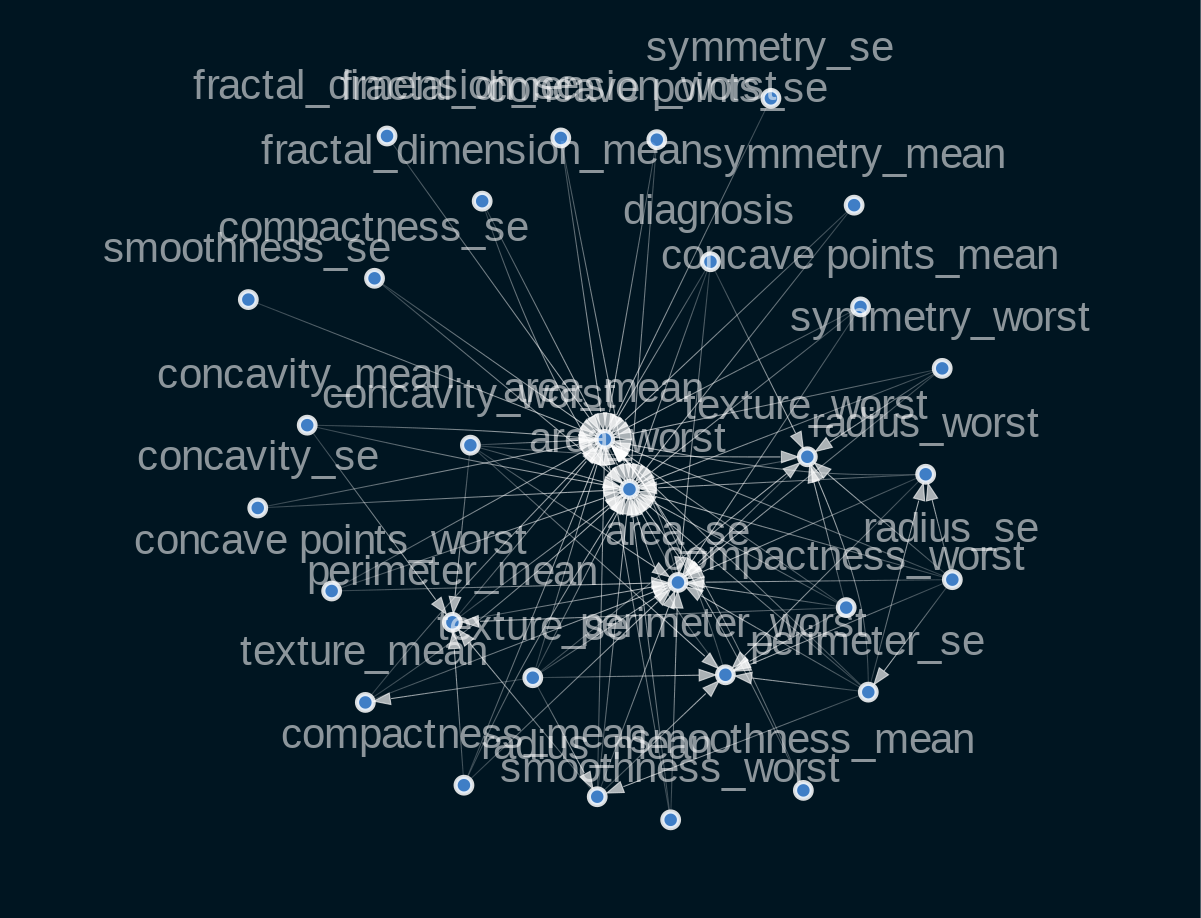

In [23]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))